# Wildfires

In this notebook, we will perform a **wildfire exposure assessment** for transportation infrastructure, specifically focusing on roads. The assessment is based on combining hazard data (e.g., historical footprints of wildfires) with spatial information on road infrastructure to understand how wildfires could impact road infrastructure.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., roads) and hazard data (e.g., fire footprints) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the exposure assessment:**  
   We will overlay the road infrastructure data with data on historical wildfire footprints.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated damage using graphs and maps to illustrate the impact on railway infrastructure.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [1]:
#!pip install damagescanner==0.9b13
#!pip install contextily
#!pip install exactextract
#!pip install lonboard

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [210]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely
from tqdm import tqdm

import matplotlib.pyplot as plt
import contextily as cx
from rasterio import features as rasterization
from affine import Affine

from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from tqdm import tqdm
import requests
from collections import OrderedDict

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from damagescanner.base_values import DICT_CIS_VULNERABILITY_FLOOD
from statistics import mode
import rioxarray  # registers the rio accessor

from lonboard import viz
from pathlib import Path

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [3]:
country_full_name = 'Togo'
country_iso3 = 'TGO'

## 2. Loading the Data
In this step, we will load four key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of transportation infrastructure (e.g., roads). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

3. **Vulnerability curves:**  
   Vulnerability curves define how the infrastructure's damage increases with the intensity of the hazard. For example, flood depth-damage curves specify how much damage occurs for different flood depths.

4. **Maximum damage values:**  
   This dataset contains the maximum possible damage (in monetary terms) that can be incurred by individual infrastructure assets. This is crucial for calculating total damage based on the vulnerability curves.

### Infrastructure Data

We will perform this example analysis for Tajikistan. To start the analysis, we first download the OpenStreetMap data from GeoFabrik. In case of locally available data, one can load the shapefiles through **gpd.read_file()**, as we show in the second cell within this section.

In [82]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

Now we load the data and read only the road data.

In [83]:
%%time
features = read_osm_data(infrastructure_path,asset_type='main_roads')

CPU times: total: 7.69 s
Wall time: 9.58 s


In [6]:
sub_types = features.object_type.unique()

In [7]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [8]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

### Hazard Data
Wildfire hazard data is exceptionally challenging to work with. The difficulty arises not only from the wide variation in extreme temperatures globally, but also from the myriad factors—such as local vegetation, fuel moisture, and differing infrastructure—that influence fire behavior in each region. Given the complexity of wildfire modelling, there are very few global datasets available to perform such an analysis.

Here we use the GlobFire Fire Perimeters dataset. It offers a comprehensive global record of individual fire events from 2002 to 2023, provided in ESRI shapefile format. This dataset is derived from the MCD64A1 burned area product, a satellite-based product developed by NASA’s MODIS team. MCD64A1 detects burned areas by analyzing changes in surface reflectance and thermal anomalies, which provides a consistent and high-resolution view of wildfire activity around the world. Each fire perimeter in the dataset is documented with a unique fire identification code, along with metadata that includes the initial and final dates, the spatial geometry, and the final burned area in hectares. For a detailed explanation of the methodologies and applications behind this dataset, please see [Artes et al. (2019)](https://www.nature.com/articles/s41597-019-0312-2). The full dataset is available for download from the [JRC Global Wildfire Information System](https://gwis.jrc.ec.europa.eu/apps/country.profile/downloads).

**Please note:** we require quite a lot of data-specific steps to get this analysis working. As such, different to the other hazards, this approach might be more difficult to quickly re-do with other wildfire data.

We will start by downloading all the wildfire data.

In [11]:
## this is the link to the 1/100 flood map for Europe
zipurl = 'https://effis-gwis-cms.s3.eu-west-1.amazonaws.com/apps/country.profile/GLOBFIRE_burned_area_full_dataset_2002_2023.zip'

# and now we open and extract the data
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall()

All data is stored as shapefiles. We can directly read them for our area by performing a clip during the reading process.

In [23]:
bbox = shapely.geometry.box(minx=features.total_bounds[0],
                    miny=features.total_bounds[1],
                    maxx=features.total_bounds[2],
                    maxy=features.total_bounds[3])

The `rasterized_wildfire_map` function converts vector-based wildfire hazard data into a rasterized format, making it compatible with GIS-based hazard and impact assessment models. This step is essential for integrating wildfire risk with other geospatial datasets, ensuring uniform resolution and analysis precision.


In [108]:
def rasterized_wildfire_map(file_path,bbox):

    country_yearly_wildfires = gpd.read_file(file_path,bbox=bbox)
        
    # List of geometries from the GeoDataFrame
    geom = [shape for shape in country_yearly_wildfires.geometry]
    
    # Define resolution
    resolution = 0.004 
    
    # Extract bounds (make sure bbox.bounds is correctly defined)
    minx, miny, maxx, maxy = bbox.bounds
    width = maxx - minx
    height = maxy - miny
    
    # Define the number of rows and columns (note the ordering: rows=y, cols=x)
    rows = int(height / resolution)
    cols = int(width / resolution)
    
    # Create an affine transform (upper-left corner is (minx, maxy))
    transform = Affine.translation(minx, maxy) * Affine.scale(resolution, -resolution)
    
    # Rasterize using the shape and coordinate system defined by the transform
    rasterized = rasterization.rasterize(
        geom,
        out_shape=(rows, cols),
        fill=np.nan,
        transform=transform,
        all_touched=False,
        default_value=1,
        dtype=None
    )

    # Assume rasterized is your NumPy array from the rasterio.features.rasterize() call
    rows, cols = rasterized.shape
    
    # Create coordinate arrays for the pixel centers:
    x_coords = minx + (np.arange(cols) + 0.5) * resolution
    y_coords = maxy - (np.arange(rows) + 0.5) * resolution
    
    # Create the DataArray and name it 'band_data'
    da = xr.DataArray(
        rasterized,
        dims=("y", "x"),
        coords={"x": x_coords, "y": y_coords},
        name="band_data"
    )
    
    # Set the affine transform and CRS (adjust the CRS if needed)
    da.rio.write_transform(transform, inplace=True)
    da.rio.write_crs("EPSG:4326", inplace=True)
    
    # Optionally, convert to a Dataset if you want to store multiple variables:
    return da.to_dataset()

In [113]:
current_dir = Path.cwd()
shp_files = list(current_dir.glob("*.shp"))

In [132]:
wildfires_per_year = {}
for file_path in tqdm(shp_files,total=len(shp_files)):
    year = str(file_path).split('_')[-1].split('.')[0]
    wildfires_per_year[year] = rasterized_wildfire_map(file_path,bbox)

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [05:33<00:00, 15.18s/it]


In [133]:
exposure_per_year = []

for year in tqdm(wildfires_per_year.keys(),total=len(wildfires_per_year)):
    country_hazard_data = wildfires_per_year[year]
    exposed_features = DamageScanner(country_hazard_data, features, pd.DataFrame(), pd.DataFrame()).exposure(disable_progress=True)#'values']
    
    exposed_features[year] = exposed_features.apply(
        lambda feature: sum([x for x in feature['coverage']]), axis=1
    )
    exposure_per_year.append(exposed_features[year])

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [04:04<00:00, 11.12s/it]


In [160]:
features['total_length'] = features.to_crs(3587).length
base_length = features.groupby('object_type')['total_length'].sum()

In [142]:
all_exposed_features = features[['osm_id','geometry','object_type']].merge(
                                    pd.concat(exposure_per_year,axis=1),
                                    left_index=True,
                                    right_index=True,
                                    how='outer')

In [150]:
exposure_by_type = all_exposed_features.groupby('object_type')[list(wildfires_per_year.keys())].sum()

In [166]:
exposure_by_type['2004'].sum()/base_length.sum()

0.14654591772290174

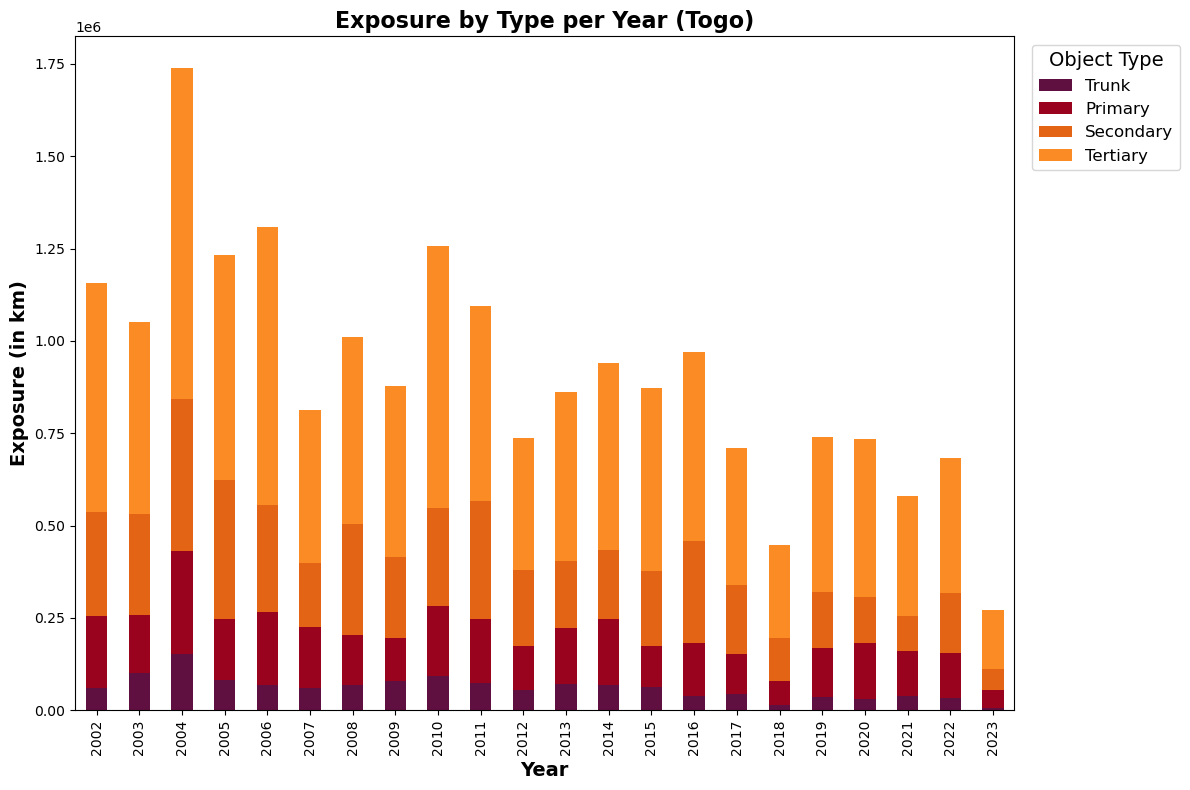

In [199]:
# Remove '_link' from the index names and group by the base type (summing the values)
exposure_grouped = exposure_by_type.copy()
exposure_grouped.index = exposure_grouped.index.str.replace('_link', '')
exposure_grouped = exposure_grouped.groupby(level=0).sum()

# Ensure the order of the rows (which will become columns after transposing)
order = ['trunk', 'primary', 'secondary', 'tertiary']
exposure_grouped = exposure_grouped.reindex(order)

# Define colors for each type:
colors = ["#5f0f40", "#9a031e", "#e36414", "#fb8b24"]

# Transpose the DataFrame so that years become the x-axis
ax = exposure_grouped.T.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)
ax.set_xlabel("Year",fontsize=14,fontweight='bold')
ax.set_ylabel("Exposure (in km)",fontsize=14,fontweight='bold')
ax.set_title(f"Exposure by Type per Year ({country_full_name})",fontsize=16,fontweight='bold')

# Capitalize legend labels
handles, labels = ax.get_legend_handles_labels()
labels = [label.capitalize() for label in labels]
ax.legend(handles, labels, title='Object Type', bbox_to_anchor=(1.01, 1), loc='upper left', 
          title_fontsize = 14, prop={'size': 12})

plt.tight_layout()
plt.show()


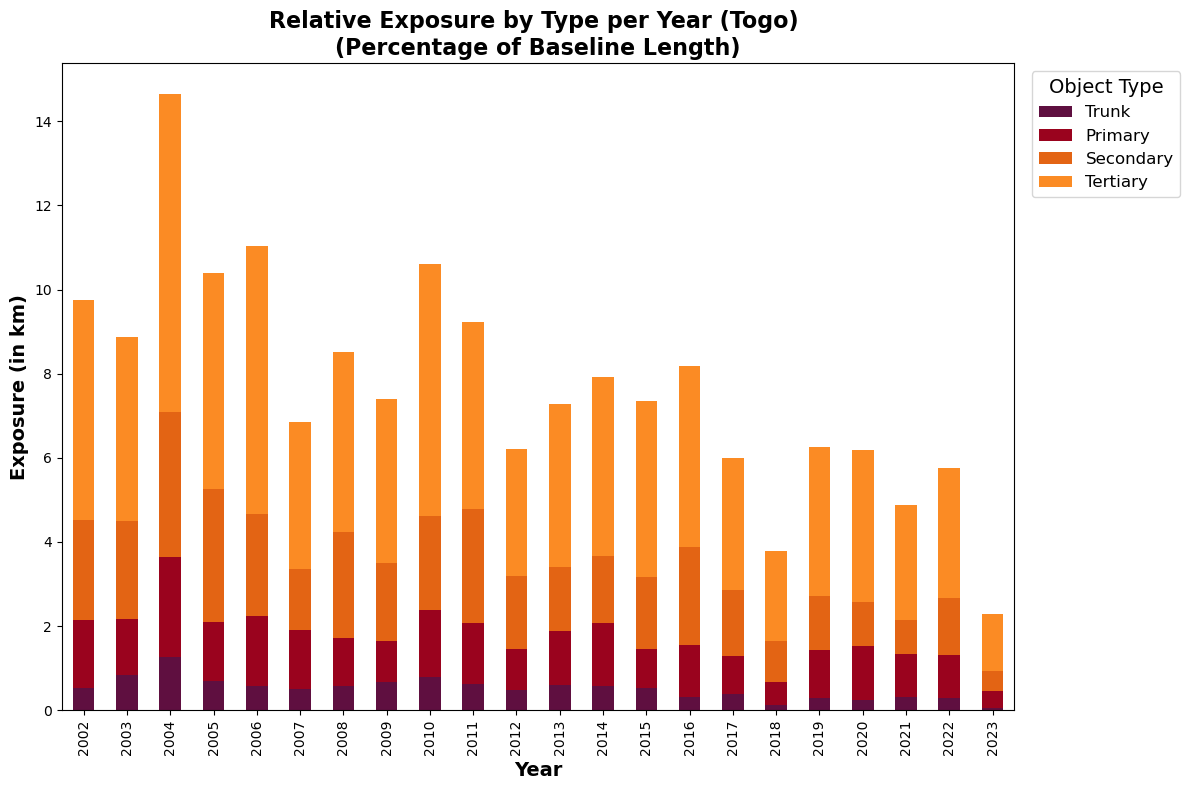

In [198]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume exposure_by_type is your DataFrame (with index like 'primary', 'primary_link', etc.)
# and base_length is your pd.Series of baseline lengths.

# --- Group exposure_by_type by removing the '_link' suffix and summing ---
exposure_grouped = exposure_by_type.copy()
exposure_grouped.index = exposure_grouped.index.str.replace('_link', '')
exposure_grouped = exposure_grouped.groupby(level=0).sum()

# --- Group base_length in a similar fashion ---
base_length_grouped = base_length.copy()
base_length_grouped.index = base_length_grouped.index.str.replace('_link', '')
base_length_grouped = base_length_grouped.groupby(level=0).sum()

# Define a consistent order
order = ['trunk', 'primary', 'secondary', 'tertiary']
exposure_grouped = exposure_grouped.reindex(order)
base_length_grouped = base_length_grouped.reindex(order)

# --- Compute the total baseline length (a scalar) ---
total_baseline = base_length_grouped.sum()

# --- Compute relative exposure per type for each year ---
# This gives, for each object type and year:
# (exposure for type in year) / (total baseline length) * 100
relative_exposure = (exposure_grouped / total_baseline) * 100

# Now, for each year, the total relative exposure is:
# relative_exposure.sum(axis=0) = (total exposure for that year) / total_baseline * 100
# For example, in 2004, this sum should be around 14% (if that is what your data imply).

# --- Define your colors for each type ---
colors = ["#5f0f40", "#9a031e", "#e36414", "#fb8b24"]

# --- Plot the stacked bar chart ---
# Transpose so that years become the x-axis
ax = relative_exposure.T.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)
ax.set_xlabel("Year",fontsize=14,fontweight='bold')
ax.set_ylabel("Exposure (in km)",fontsize=14,fontweight='bold')
ax.set_title(f"Relative Exposure by Type per Year ({country_full_name}) \n(Percentage of Baseline Length)",
             fontsize=16,fontweight='bold')

# Capitalize legend labels
handles, labels = ax.get_legend_handles_labels()
labels = [label.capitalize() for label in labels]
ax.legend(handles, labels, title='Object Type', bbox_to_anchor=(1.01, 1), loc='upper left', 
          title_fontsize = 14, prop={'size': 12})
plt.tight_layout()
plt.show()


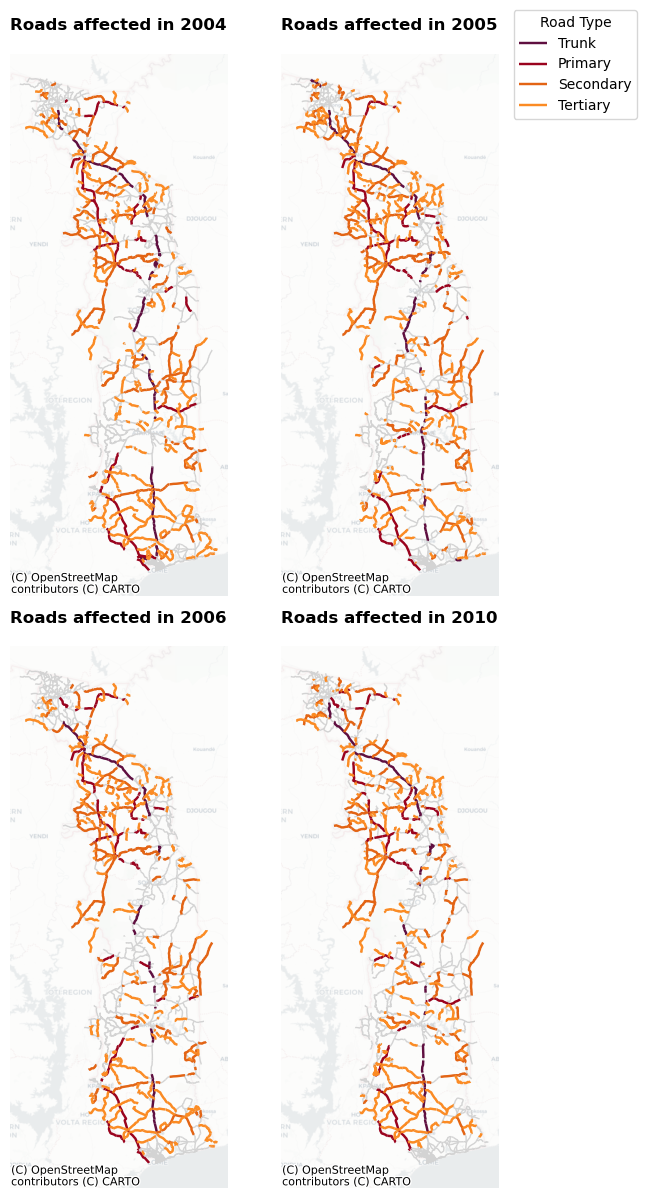

In [214]:
# Ensure the GeoDataFrame 'all_exposed_features' is in EPSG:3857 (required for Contextily)
if all_exposed_features.crs.to_string() != 'EPSG:3857':
    all_exposed_features = all_exposed_features.to_crs(epsg=3857)

# Create a new column 'base_type' that removes the '_link' suffix so that _link roads become part of their base type
all_exposed_features['base_type'] = all_exposed_features['object_type'].str.replace('_link', '')

# Define the years to plot
years = [2004, 2005, 2006, 2010]

# Define the color mapping for the four road types
color_map = {
    'trunk': '#5f0f40',
    'primary': '#9a031e',
    'secondary': '#e36414',
    'tertiary': '#fb8b24'
}

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(6, 12))
axes = axes.flatten()

for ax, year in zip(axes, years):
    # Plot all roads in light grey as the background
    all_exposed_features.plot(ax=ax, color='lightgrey', linewidth=1)
    
    # Filter for roads affected in this year (non-null value in the year's column)
    affected = all_exposed_features[all_exposed_features[str(year)].notnull()]
    
    # Limit to the four main road types using the 'base_type' column
    affected = affected[affected['base_type'].isin(color_map.keys())]
    
    # Plot each road type with its specified color
    for road_type, color in color_map.items():
        sub = affected[affected['base_type'] == road_type]
        if not sub.empty:
            sub.plot(ax=ax, color=color, linewidth=1.75, label=road_type.capitalize())
    
    # Add basemap using Contextily with a partially transparent CartoDB Positron layer
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, alpha=0.5)
    
    ax.set_title(f"Roads affected in {year}",fontweight='bold')
    ax.set_axis_off()

# Create a consolidated legend using the labels from the first axis
handles, labels = axes[0].get_legend_handles_labels()
unique = OrderedDict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), title="Road Type", bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()
